In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt

2021-11-01 01:44:41.215772: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-01 01:44:41.215809: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
transition_window =3

warmup_start = '20210428'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

log_dir = './logs/new_warmup'


# Learning rate
learning_rate = 1e-4

In [3]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [4]:
class Comp(Enum):
    A = 0
    M = 1
    #X = 2
    #G = 3
    
class Vax(Enum):
    total = -1
    no = 0
    yes = 1

In [5]:
# get warmup arrays, splitting on vaccination status
warmup_asymp, warmup_mild, warmup_extreme = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end,
                                                          0,0,0)

# re-combine
warmup_asymp = warmup_asymp[Vax.no.value] + warmup_asymp[Vax.yes.value]

In [6]:
synth_delta = 0.99
synth_T_serial = 5.8
synth_rho_M = 0.76
synth_lambda_M = 4.7
synth_nu_M = 3.1

In [7]:
param_scale_pct = 0.01

In [8]:
delta = {}
delta[Vax.total.value] = {}
delta[Vax.total.value]['prior'] = {'a': 18, 'b': 2}
# delta is 0-1, so we will sigmoid the output of the variational posterior
# Here we use a reverse sigmoid to convert from a mean of 0.1
# scales are positive, so we invert sofplus


delta[Vax.total.value]['posterior_init'] = {'loc': np.log(synth_delta/(1-synth_delta)),
                                            'scale':tfp.math.softplus_inverse(param_scale_pct*synth_delta)}

T_serial = {}
T_serial[Vax.total.value] = {}
T_serial[Vax.total.value]['prior'] ={'loc':5.8, 'scale':1}
# T_serial is positive, so we will softplus the output of the variational posterior
# Here we use a reverse softplus to convert from a mean of 5.8
# I cant figure out the math to do for the scale parameter
T_serial[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(synth_T_serial),
                                         'scale':tfp.math.softplus_inverse(param_scale_pct*synth_T_serial)}


rho_M = {}
rho_M[Vax.total.value] = {}
rho_M[Vax.total.value]['prior'] = {'a': 31.8, 'b': 10.3}
# rho is 0-1, so we will sigmoid the output of the variational posterior
# Here we use a reverse sigmoid to convert from a mean of 0.76
# I cant figure out the math to do for the scale parameter
rho_M[Vax.total.value]['posterior_init'] = {'loc': np.log(synth_rho_M/(1-synth_rho_M)),
                                      'scale':tfp.math.softplus_inverse(param_scale_pct*synth_rho_M)}

lambda_M = {}
lambda_M[Vax.total.value] = {}
lambda_M[Vax.total.value]['prior'] = {'loc': 4.7, 'scale': 1}
# lambda is positive, so we will softplus the output of the variational posterior
# Here we use a reverse softplus to convert from a mean of 4.7
# I cant figure out the math to do for the scale parameter
lambda_M[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(synth_lambda_M),
                                         'scale':tfp.math.softplus_inverse(param_scale_pct*synth_lambda_M)}

nu_M = {}
nu_M[Vax.total.value] = {}
nu_M[Vax.total.value]['prior'] = {'loc': 3.1, 'scale': 1.2}
# nu is positive, so we will softplus the output of the variational posterior
# Here we use a reverse softplus to convert from a mean of 3.1
# I cant figure out the math to do for the scale parameter
nu_M[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(synth_nu_M),
                                     'scale':tfp.math.softplus_inverse(param_scale_pct*synth_nu_M)}


2021-11-01 01:44:43.377998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-01 01:44:43.378215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-01 01:44:43.378259: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-01 01:44:43.378290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-01 01:44:43.378328: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [9]:
warmup_A_params = {}
warmup_A_params[Vax.total.value] = {}
warmup_A_params[Vax.total.value]['prior'] = []
warmup_A_params[Vax.total.value]['posterior_init'] = []

for day in range(transition_window):
    warmup_A_params[Vax.total.value]['prior'].append({'loc': warmup_asymp[day],
                                                'scale': warmup_asymp[day]/10})
    # must be positive so reverse softplus the mean
    warmup_A_params[Vax.total.value]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]),dtype=tf.float32),
                                                         'scale': tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]*param_scale_pct),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})

In [10]:
model = CovidModel([Vax.total], [Comp.A, Comp.M],
                 transition_window,
                 delta, T_serial, rho_M, lambda_M, nu_M,
                 warmup_A_params, posterior_samples=1000)
loss = LogPoissonProb() 
optimizer = tf.keras.optimizers.SGD(
    learning_rate=learning_rate, #momentum=0.98, nesterov=False, name='SGD'
)

In [11]:
x_train = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)
y_test = tf.cast(df.loc[train_start:test_end,'mild'], dtype=tf.float32)


In [12]:
warmup_A_params

{-1: {'prior': [{'loc': 2518.60923786445, 'scale': 251.86092378644497},
   {'loc': 2520.22371776634, 'scale': 252.022371776634},
   {'loc': 2518.626798999444, 'scale': 251.8626798999444}],
  'posterior_init': [{'loc': <tf.Tensor: shape=(), dtype=float32, numpy=2518.6091>,
    'scale': <tf.Tensor: shape=(), dtype=float32, numpy=25.186092>},
   {'loc': <tf.Tensor: shape=(), dtype=float32, numpy=2520.2236>,
    'scale': <tf.Tensor: shape=(), dtype=float32, numpy=25.202238>},
   {'loc': <tf.Tensor: shape=(), dtype=float32, numpy=2518.6267>,
    'scale': <tf.Tensor: shape=(), dtype=float32, numpy=25.186268>}]}}

In [13]:
delta

{-1: {'prior': {'a': 18, 'b': 2},
  'posterior_init': {'loc': 4.595119850134589,
   'scale': <tf.Tensor: shape=(), dtype=float32, numpy=-4.610266>}}}

In [14]:
A_vals = []
M_vals =[]
for day in range(transition_window):
    A_vals.append(warmup_A_params[-1]['prior'][day]['loc'])

for day in range(len(x_train)):
    yesterday_asymp = A_vals[-1]
    
    today_asymp = yesterday_asymp*synth_delta*x_train[day]**(1/synth_T_serial)
    A_vals.append(today_asymp)
    
    today_M = 0
    pi_M=[]
    for j in range(transition_window):
        
        
        lambda_M_fix = synth_lambda_M
        nu_M_fix = synth_nu_M
        poisson_dist = scipy.stats.poisson(lambda_M_fix)
        pi_M_j_ago = poisson_dist.logpmf(j+1)/nu_M_fix
        
        pi_M.append(pi_M_j_ago)
    
    pi_M = scipy.special.softmax(pi_M)
        
    for j in range(transition_window):
        j_ago_asymp = A_vals[day-j-1]
        today_M += j_ago_asymp*synth_rho_M*pi_M[j]
        
    M_vals.append(today_M)

Text(0.5, 1.0, 'Asymptomatic Compartment')

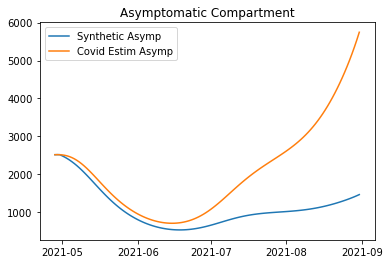

In [15]:
plt.plot(df.loc[warmup_start:test_end].index.values, A_vals, label='Synthetic Asymp')
plt.plot(df.loc[warmup_start:test_end].index.values, df.loc[warmup_start:test_end,'asymp'].values, label='Covid Estim Asymp')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Asymptomatic Compartment')

Text(0.5, 1.0, 'Mild Compartment')

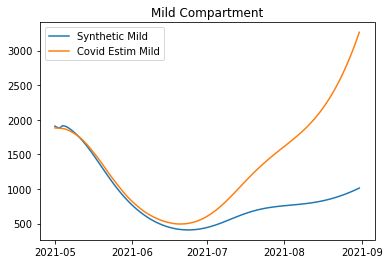

In [16]:
plt.plot(df.loc[train_start:test_end].index.values, M_vals, label='Synthetic Mild')
plt.plot(df.loc[train_start:test_end].index.values, df.loc[train_start:test_end,'mild'].values, label='Covid Estim Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Mild Compartment')

In [17]:
model = CovidModel([Vax.total], [Comp.A, Comp.M],
                 transition_window,
                 delta, T_serial, rho_M, lambda_M, nu_M,
                 warmup_A_params, posterior_samples=1000)
loss = LogPoissonProb() 

In [33]:
x_train = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)
y_test = tf.cast(df.loc[train_start:test_end,'mild'], dtype=tf.float32)

with tf.GradientTape() as tape:
    result = model.call(x_train)
    loss_val = loss(y_test, result)
    loss_val += sum(model.losses)

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=7.96352>
delta_scale: 0.00990759115666151
Pre-softmax pi_M [[-1.019933   -1.0198661  -1.0379316  ... -1.0216193  -1.0067754
  -1.0165745 ]
 [-0.7434962  -0.74345344 -0.75664455 ... -0.7447294  -0.7339271
  -0.7410578 ]
 [-0.5986015  -0.5977261  -0.6073931  ... -0.6002523  -0.5925032
  -0.5976983 ]]
Delta 0.9996414184570312
T serial 5.0342302322387695
rho_M 0.6741719245910645
lambda M 4.547292232513428
pi_M [0.25652698 0.3426733  0.39248416]


In [19]:
grads = tape.gradient(loss_val, model.trainable_weights)
grads

2021-11-01 01:44:46.354484: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


[<tf.Tensor: shape=(), dtype=float32, numpy=-37420.484>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.71769863>,
 <tf.Tensor: shape=(), dtype=float32, numpy=297.32434>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.98725146>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-10183.582>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.2471976>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.007919095>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0023096825>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-9.6512575>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.011777837>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0049552754>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0010990053>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0088002365>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0018924602>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-16.869581>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.3296092>]

In [20]:
loss_val

<tf.Tensor: shape=(), dtype=float32, numpy=21815.334>

In [21]:
loss_val

<tf.Tensor: shape=(), dtype=float32, numpy=21815.334>

In [22]:
with tf.GradientTape() as tape:
    result = model.call(x_train)
    loss_val = loss(tf.cast(np.array(M_vals),dtype=tf.float32), result)
    loss_val += sum(model.losses)

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.009900001809000969
Pre-softmax pi_M [[-1.0235089  -0.9952162  -1.001007   ... -1.0119407  -1.0318598
  -1.0077869 ]
 [-0.7461369  -0.725512   -0.72969997 ... -0.7376979  -0.75226194
  -0.7346448 ]
 [-0.598769   -0.5860922  -0.58759344 ... -0.59216833 -0.60284334
  -0.5920157 ]]
Delta 0.9897124171257019
T serial 5.599632263183594
rho_M 0.755867600440979
lambda M 4.561206340789795
pi_M [0.2573175  0.34257182 0.3929834 ]


In [23]:
grads = tape.gradient(loss_val, model.trainable_weights)
grads

[<tf.Tensor: shape=(), dtype=float32, numpy=883.66486>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.426243>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-283.17828>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.3236551>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-533.375>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4756449>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.009020777>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0020839248>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.5049486>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.007400942>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00096845>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0012640016>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0039745634>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0018249605>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.8914249>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.4298519>]

In [24]:
model.trainable_weights

[<tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>,
 <tf.Variable 'delta_A_scale_-1:0' shape=() dtype=float32, numpy=-4.610266>,
 <tf.Variable 'T_serial_A_loc_-1:0' shape=() dtype=float32, numpy=5.796968>,
 <tf.Variable 'T_serial_A_scale_-1:0' shape=() dtype=float32, numpy=-2.818172>,
 <tf.Variable 'rho_M_loc_-1:0' shape=() dtype=float32, numpy=1.1526796>,
 <tf.Variable 'rho_M_scale_-1:0' shape=() dtype=float32, numpy=-4.875805>,
 <tf.Variable 'lambda_M_loc_-1:0' shape=() dtype=float32, numpy=4.690863>,
 <tf.Variable 'lambda_M_scale_-1:0' shape=() dtype=float32, numpy=-3.0340157>,
 <tf.Variable 'nu_M_loc_-1:0' shape=() dtype=float32, numpy=3.0539045>,
 <tf.Variable 'nu_M_scale_-1:0' shape=() dtype=float32, numpy=-3.458228>,
 <tf.Variable 'warmup_A_loc_0_-1:0' shape=() dtype=float32, numpy=2518.6091>,
 <tf.Variable 'warmup_A_scale_0_-1:0' shape=() dtype=float32, numpy=25.186092>,
 <tf.Variable 'warmup_A_loc_1_-1:0' shape=() dtype=float32, numpy=2520.2236>,
 <tf.Vari

In [25]:
loss_val

<tf.Tensor: shape=(), dtype=float32, numpy=829.1327>

In [26]:
loss_val

<tf.Tensor: shape=(), dtype=float32, numpy=829.1327>

In [27]:
model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
model.fit(x=np.asarray([x_train]), y=np.asarray([y_test]),
         epochs=20, batch_size=0,
        callbacks=[])

Epoch 1/20
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.009900001809000969
Pre-softmax pi_M [[-0.9962262  -1.0162888  -1.0217007  ... -1.0374718  -1.0207511
  -1.0292264 ]
 [-0.7262318  -0.7408425  -0.7447855  ... -0.75636244 -0.74413335
  -0.7502906 ]
 [-0.5860906  -0.5958874  -0.59935087 ... -0.6059624  -0.5969819
  -0.60256445]]
Delta 0.9896848201751709
T serial 5.612987995147705
rho_M 0.7549872398376465
lambda M 4.5531511306762695
pi_M [0.25679618 0.3426155  0.39245573]
1/1 [==============================] - 3s 3s/step - loss: 21776.6738
Epoch 2/20
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=8.334344>
delta_scale: 0.009907398372888565
Pre-softmax pi_M [[-1.0201615  -1.0202935  -1.0327436  ... -0.99439263 -1.0289538
  -1.0321686 ]
 [-0.7436657  -0.74376124 -0.7529279  ... -0.7248782  -0.7500864
  -0.75242215]
 [-0.5993     -0.59930706 -0.60299605 ... -0.58357584 -0.6026148
  -0.6066581 ]]
Delta 0.999752

1/1 [==============================] - 2s 2s/step - loss: 1118.6555
Epoch 15/20
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=8.029776>
delta_scale: 0.009907638654112816
Pre-softmax pi_M [[-1.0181764  -1.0157214  -0.9972812  ... -1.0322504  -1.0236418
  -1.0319254 ]
 [-0.7422161  -0.740428   -0.72698516 ... -0.7525531  -0.7461999
  -0.7522413 ]
 [-0.5973731  -0.5965851  -0.5856729  ... -0.6029572  -0.6006882
  -0.6050369 ]]
Delta 0.9996652603149414
T serial 5.094981670379639
rho_M 0.6721198558807373
lambda M 4.556062698364258
pi_M [0.25642797 0.34256116 0.39279288]
1/1 [==============================] - 2s 2s/step - loss: 1117.4413
Epoch 16/20
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=8.019592>
delta_scale: 0.009907610714435577
Pre-softmax pi_M [[-1.0283004  -1.0234191  -1.0479275  ... -1.0308707  -0.99926156
  -1.0093116 ]
 [-0.7496284  -0.74603945 -0.7639469  ... -0.7514701  -0.7284276
  -0.7357954 ]
 [-0.6016135  -0.60110676 

In [28]:
model.trainable_weights

[<tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=7.96352>,
 <tf.Variable 'delta_A_scale_-1:0' shape=() dtype=float32, numpy=-4.609496>,
 <tf.Variable 'T_serial_A_loc_-1:0' shape=() dtype=float32, numpy=5.253421>,
 <tf.Variable 'T_serial_A_scale_-1:0' shape=() dtype=float32, numpy=-2.8265586>,
 <tf.Variable 'rho_M_loc_-1:0' shape=() dtype=float32, numpy=0.7510938>,
 <tf.Variable 'rho_M_scale_-1:0' shape=() dtype=float32, numpy=-4.8773704>,
 <tf.Variable 'lambda_M_loc_-1:0' shape=() dtype=float32, numpy=4.6908817>,
 <tf.Variable 'lambda_M_scale_-1:0' shape=() dtype=float32, numpy=-3.0340204>,
 <tf.Variable 'nu_M_loc_-1:0' shape=() dtype=float32, numpy=3.0302262>,
 <tf.Variable 'nu_M_scale_-1:0' shape=() dtype=float32, numpy=-3.4582214>,
 <tf.Variable 'warmup_A_loc_0_-1:0' shape=() dtype=float32, numpy=2518.6091>,
 <tf.Variable 'warmup_A_scale_0_-1:0' shape=() dtype=float32, numpy=25.186092>,
 <tf.Variable 'warmup_A_loc_1_-1:0' shape=() dtype=float32, numpy=2520.2236>,
 <tf.

In [29]:
r_t

NameError: name 'r_t' is not defined

In [ ]:
x_train

In [ ]:
len(y_test)

In [ ]:
A_vals

In [ ]:
len(M_vals)

In [ ]:
model.trainable_weights

In [ ]:
np.log(-2.9/(1-2.9))

In [ ]:
x_train

In [ ]:
1.1**(1/5.8)

In [ ]:
df.loc[train_start:train_end, 
       'asymp'].values

In [ ]:
y_test

In [ ]:
tf.reduce_mean(result, axis=1)

Text(0.5, 1.0, 'Mild Compartment')

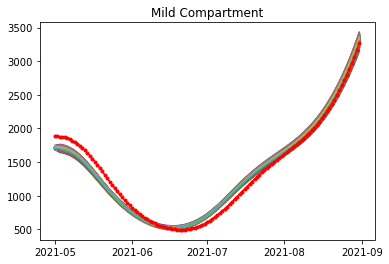

In [36]:

plt.plot(df.loc[train_start:test_end].index.values, result, label='Modeled Mild')
plt.plot(df.loc[train_start:test_end].index.values, y_test,'r.-', label='"True" Mild')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
#plt.legend()
plt.title('Mild Compartment- fitting to "real" data')

In [ ]:
x_train

In [ ]:
y_test

In [ ]:
tf.cast(df.loc[train_start:test_end,'asymp'], dtype=tf.float32)

In [ ]:
df

In [ ]:

covid_estim_df = pd.read_csv("../data/covidestim/20210901.csv")

In [ ]:
covid_estim_df.columns

In [ ]:
np.mean(grads)

In [ ]:
len(model.losses)

In [ ]:
model.losses[-8:]

In [ ]:
model.losses[:8]

In [ ]:
model.losses[-8:]

In [ ]:
model.losses